In [9]:

import numpy as np
import datetime as dt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import glob
from netCDF4 import Dataset
import copy
import gc
import os

import sys
# sys.path.insert(0, '/Users/h/Github/geo_data_group/')
import grid_set as gs

import ant_plus
from imp import reload
reload(ant_plus)
reload(gs)

<module 'grid_set' from '/Users/h/PREMELT/Ant+/grid_set.py'>

In [10]:
file = 'Example_Merge/L2_ice_leads_West_Weddell_2019-09-01T06-52_2019-09-30T16-53.nc'
track=ant_plus.CS2_track(file,add_attr=True)
track.print_time()
fig_dir = file.split('.nc')[0]+'/'
check_dir = os.path.dirname(fig_dir)
if not os.path.exists(check_dir):
    os.makedirs(check_dir)

2019-09-01T06:52:56.312535--2019-09-30T16:53:21.795921


In [11]:
lon_r = np.min(track.lon_20_ku),np.max(track.lon_20_ku)
lat_r = np.min(track.lat_20_ku),np.max(track.lat_20_ku)
lon_r,lat_r

((-57.9164476, -40.000136999999995), (-75.51515979999999, -63.000023299999995))

In [12]:
track.list_vars(['ANOM','flag','interp'])

['ocean_tide_20_ku_ANOM_DTU_fes',
 'range_1_20_ku_ANOM_ISat_2step',
 'range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice',
 'range_1_20_ku_ANOM_DTU_imp_th70',
 'range_1_20_ku_ANOM_DTU_th70',
 'range_1_20_ku_ANOM_DTU_gauss',
 'range_1_20_ku_ANOM_MSSL_D',
 'range_1_20_ku_ANOM_MSSL_S',
 'range_1_20_ku_ANOM_LEGOS_GPOD_All',
 'range_1_20_ku_ANOM_CLS',
 'mean_sea_surf_20_ku_ANOM_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15',
 'mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU21',
 'atm_geo_corrections_sum_ANOM_ISat',
 'atm_geo_corrections_sum_ANOM_LEGOS_GPOD',
 'ssha_interp_20_ku',
 'ssha_interp_20_ku_LEGOS_GPOD_Ice',
 'ssha_interp_20_ku_LEGOS_GPOD_Lead',
 'ssha_interp_20_ku_ANOM_LEGOS_GPOD',
 'ssha_interp_20_ku_ANOM_LEGOS_GPOD',
 'flag_surf_type_class_20_ku',
 'flag_surf_type_20_ku_CLS',
 'flag_surf_type_20_ku_LEGOS_GPOD']

In [13]:
load_list = track.list_vars(['ANOM','flag','interp','height','geoid','ssha'])
track.add_vars(load_list)

Got a grid res =  36  x  54
Note that all grid info is in nx x ny grids, whilst data is in nx x ny


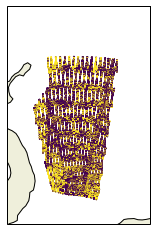

In [8]:
#$### map projection
m = ccrs.Orthographic(np.mean(lon_r),np.mean(lat_r))
proj_cart = ccrs.PlateCarree() 
f = plt.figure()
G= gs.grid_set(m)

lat_shift= 3 ### add to top lat to fix curvature on map edges
ax = f.add_subplot(1,1,1,projection=m)
ax.set_extent([lon_r[0]-2, lon_r[1]+4, lat_r[0]-2, lat_r[1]+2+lat_shift])#, ccrs.PlateCarree())
G.set_grid_dxy(40e3,40e3,ax)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
# plt.close()
x,y = G.mplot(track.lon_20_ku,track.lat_20_ku)
ax.scatter(x,y,s=0.1,c=track.flag_surf_type_class_20_ku)


In [14]:
track.flag_surf_type_20_ku_CLS_attr


{'coordinates': 'lon_20_ku lat_20_ku',
 'flag_values': '0b, 1b, 2b , 3b',
 'flag_meanings': 'unknown/mixed ocean sea_ice lead',
 'long_name': 'surface type flag',
 'comment': 'A 4-state surface type mask for Cryosat2 data from the LEGOS GPOD along track data.Flag file converted from the three original supplied flag files: flag_floes_meas_valid_20hz,flag_leads_meas_valid_20hz,flag_open_ocean_meas_valid_20h'}

In [15]:
track.flag_surf_type_class_20_ku_attr


{'comment': 'Flag indicating the surface type determined by analysis of the waveform and aux values. Unused in LRM mode. Over ocean in SARIn mode, the SAR discriminator for sea ice is used.',
 'coordinates': 'lon_20_ku lat_20_ku',
 'flag_mask': array([  1,   2,   4,   8,  16,  32,  64, 128, 256], dtype=int16),
 'flag_meanings': 'lrm_undefined lrm_ocean lrm_land_ice sarin_undefined sarin_valid sar_undefined sar_ocean sar_sea_ice sar_lead',
 'long_name': 'discriminated surface type'}

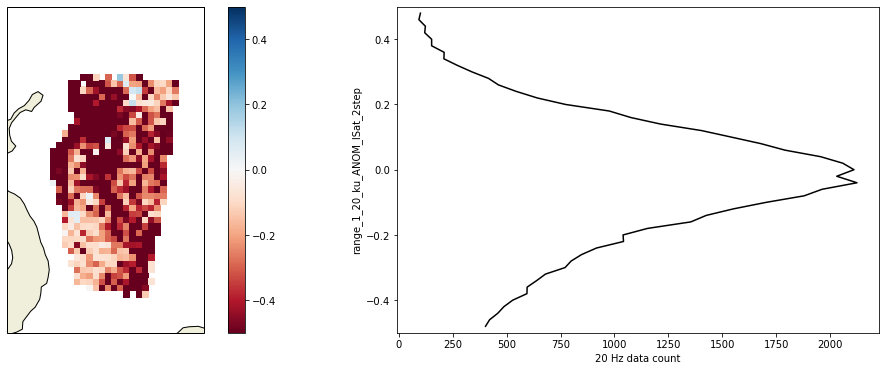

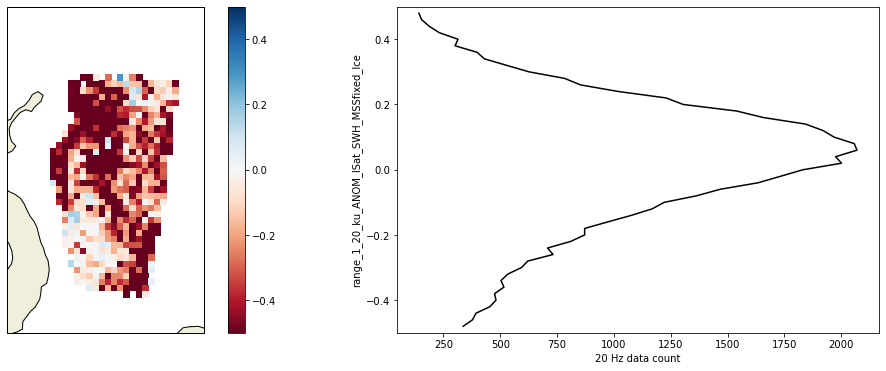

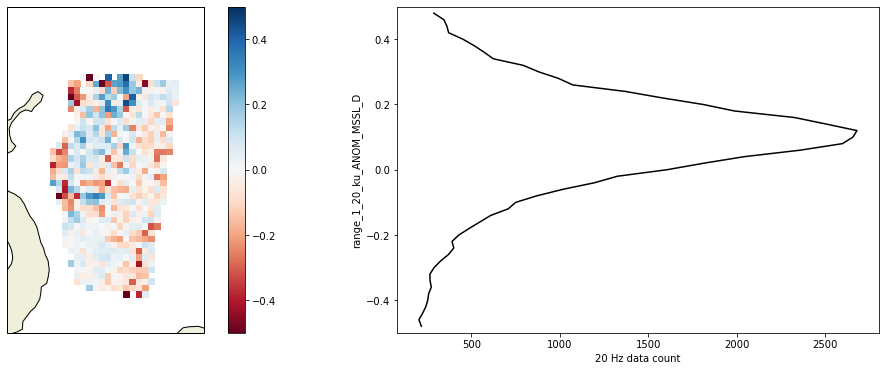

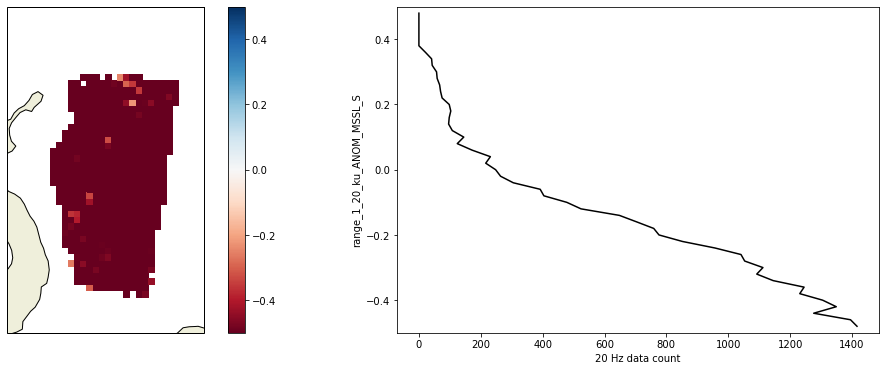

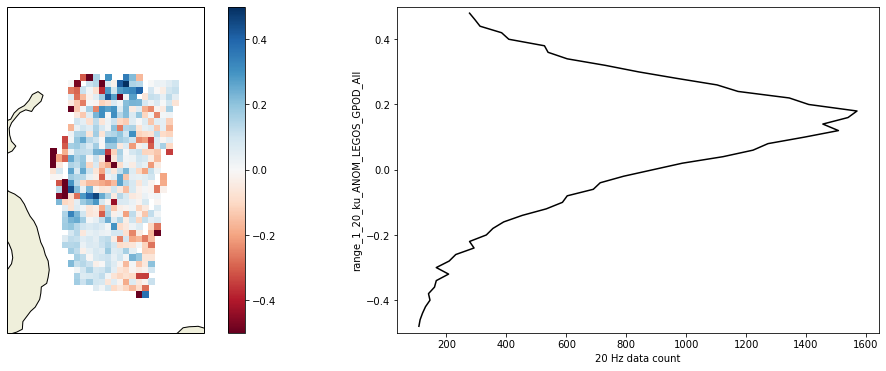

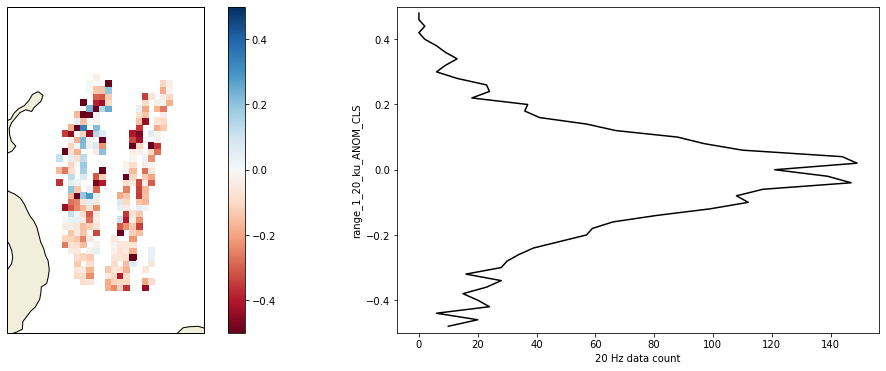

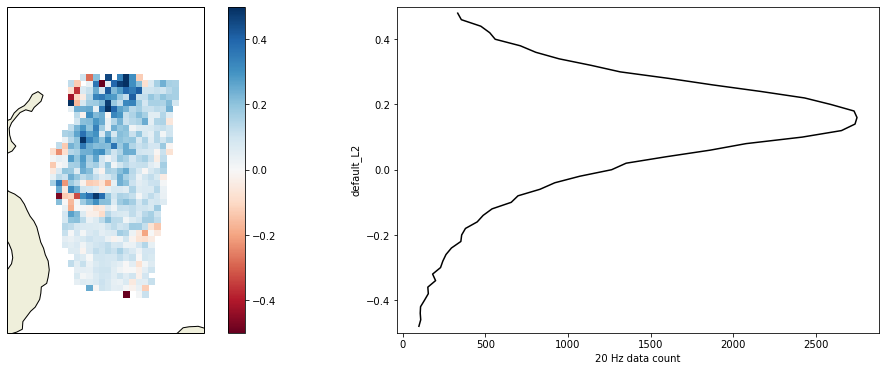

In [27]:
### Leads
# p_vars = [p for p in track.vars if 'LEGOS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'DTU' in p and 'LEGOS' not in p]
# p_vars = [p for p in track.vars if 'CLS' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'atm' in p and 'flag' not in p]
# p_vars = [p for p in track.vars if 'interp' in p]
# p_vars = [p for p in track.vars if 'mean_sea' in p]
# p_vars = [p for p in track.vars if 'range' in p and 'ANOM' in p]
p_vars = [p for p in track.vars if 'range' in p and 'DTU' not in p] # no sea ice in DTU
# p_vars = [p for p in track.vars if 'ANOM' in p and 'atm' in p] # no sea ice in DTU
p_vars = p_vars+['default_L2'] #### extra for not adding an anomally
SaveT = 'Freeboard_'
h_auto = False ## h_(min,max) calculated from data range
h_sym = False ## h_(min,max) forced to symmetric about 0
# h_trim = False ### centiles to knock off, set the percentiles to remove
h_trim = 1
# h_trim = 5 ### takes away the 5 and 95 percentile before binning/histogram
# h_min = -2.5
# h_max =  0.0
# h_min = 0.9
# h_max =  3.1
h_min = -0.5
h_max =  0.5
hard_min = -10.0 ### extras to remove crazy outliers
hard_max =  10.0
#### surface type options
LG_CLS_flag = 2 ### for CLS and legos 2 => sea_ice # 1 ocean, 2 ice, 3 lead
#### a mask is always require from Bl-D L2
# msk = np.ones_like(track.time_20_ku,dtype=bool) ### all data
msk = track.flag_surf_type_class_20_ku ==  128 ### sea ice
# msk[track.flag_surf_type_class_20_ku ==  64] = True ### also ocean
h_bins = np.arange(h_min,h_max,0.02)
for v in p_vars:
#     x = getattr(track,v).copy()
    if 'default' in v: 
#         x = track.height_1_20_ku - track.geoid_20_ku #### to make DOT
        x = track.ssha_20_ku - track.ssha_interp_20_ku #### to make FB
    else:
        x = getattr(track,v).copy()
#         x = -x + track.height_1_20_ku - track.geoid_20_ku #### to make DOT
        x = -x + track.ssha_20_ku - track.ssha_interp_20_ku #### to make FB
    if 'GPOD' in v:
        msk[track.flag_surf_type_20_ku_LEGOS_GPOD!=LG_CLS_flag] = 0
    else:
        msk = track.flag_surf_type_class_20_ku ==  128 ### sea ice
    if 'CLS' in v:
        msk[track.flag_surf_type_20_ku_CLS!=LG_CLS_flag] = 0
    else:
        msk = track.flag_surf_type_class_20_ku ==  128 ### sea ice
#     if 'class' in v:
#         x[x<64] = 0
#         x[x==256] = 3
#         x[x==128] = 2
#         x[x==64] = 1
    x[x.mask] = np.nan
    msk[x>hard_max] = 0
    msk[x<hard_min] = 0
    if h_trim:
        h_t0,h_t1 = np.nanpercentile(x[msk],[h_trim,100-h_trim])
        msk[x>h_t1] = 0
        msk[x<h_t0] = 0
    x = x[msk]
    if h_auto:
        h_min,h_max = np.nanpercentile(x,[0.5,99.5])
        if h_sym:
            h_max = np.maximum(np.abs(h_min),np.abs(h_max))
            h_min = -h_max
        h_bins = np.arange(h_min,h_max,(h_max-h_min)/50)
    
    
    plot_array  = G.bin_list(x,#track.mean_sea_surf_20_ku_ANOM_LEGOS_GPOD_DTU15,
                            track.lon_20_ku[msk],track.lat_20_ku[msk],xy_order=0)
#                              bin_func = func_u)

    f = plt.figure(figsize=[19,6])
    ax = f.add_subplot(1,2,1,projection=m)
#     ax.set_extent([-180, 180, -90, -50], proj_cart)
    ax.set_extent([lon_r[0]-2, lon_r[1]+2, lat_r[0]-2, lat_r[1]+2+lat_shift])#, ccrs.PlateCarree())
    s = ax.pcolormesh(G.xpts,G.ypts,plot_array,
                     cmap = 'RdBu',vmin = h_min,vmax = h_max)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    plt.colorbar(s,shrink=1.0,pad=0.05)
    
    ax = f.add_subplot(1,2,2)
    hist = np.histogram(x,bins=h_bins)[0]
    ax.plot(hist,h_bins[:-1] + np.diff(h_bins),'-k')
    ax.set_ylim([h_min,h_max])
    ax.set_ylabel(v)
    ax.set_xlabel('20 Hz data count')
#     f.savefig(fig_dir+SaveT+v+'_map_hist.png',bbox_inches='tight')

    plt.show()

In [21]:
for v in track.vars:
#     if 'range' in v and 'ANOM' not in v:
#     if 'range' in v and 'ISat' in v:
    if 'ANOM' in v:
        print('-----')
        print(v)
        print('-----')
        if hasattr(track,v+'_attr'):
            attr = getattr(track,v+'_attr')
            for key, value in attr.items():
                print(key, ' : ', value)
        x = copy.copy(getattr(track,v))
        if type(x.mask) == np.ndarray:
            x[x.mask] = np.nan
        print('Distribution of '+v+' = '+' , '.join('{:.3}'.format(pc) for pc in np.nanpercentile(x,[25,50,75])))

-----
ocean_tide_20_ku_ANOM_DTU_fes
-----
Description  :  Anomaly from L2 ocean_tide_eq+ocean_tide to DTU_fes ocean tide
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of ocean_tide_20_ku_ANOM_DTU_fes = -0.0681 , 0.00124 , 0.0441
-----
range_1_20_ku_ANOM_ISat_2step
-----
Description  :  Anomaly from L2 range to _ISat_2step retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_ISat_2step = 0.0029 , 0.0728 , 0.189
-----
range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice
-----
Description  :  Anomaly from L2 range to _ISat_SWH_MSSfixed_Ice retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_ISat_SWH_MSSfixed_Ice = -0.424 , -0.0719 , 0.128
-----
range_1_20_ku_ANOM_DTU_imp_th70
-----
Description  :  Anomaly from L2 range to _DTU_imp_th70 retracker range
coordinates  :  lon_poca_20_ku lat_poca_20_ku
Units  :  m
Distribution of range_1_20_ku_ANOM_DTU_imp_th70 = -0.217 